In [1]:
from typing import Callable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from matplotlib import cm  # color map

# Define environment 

In [2]:
def draw_card() -> int:
    """Simulates the drawing mechanism of Easy21. 0 is red and 1 is black.
    The function returns the amount to be summed to the current state.

    Returns:
        int: Amount to be summed to the player's total.
    """

    card_number = np.random.randint(1, 11)
    probability_draw = np.random.randint(3)
    if probability_draw == 0:
        return -card_number
    else:
        return card_number


def terminal_condition(x: int):
    """Checks that the sum x correspond to one of the "going bust" criterion.

    Args:
        x (int): Player's total.

    Returns:
        _type_: Boolean indicating if the condition of going bust is met
    """
    condition = (x < 1) or (x > 21)
    return condition


def play_dealer(s: List[int]):
    """Sample a dealer's behaviour and returns the corresponding reward.

    Args:
        s (List[int]): Current state.

    Returns:
        _type_: Reward obtained by the player following the dealer's behaviour.
    """
    # Simulates the drawing of the dealer's cards
    dealer_sum = s[0]
    terminate = False

    while not terminate:
        card_drawn = draw_card()
        dealer_sum += card_drawn

        if terminal_condition(dealer_sum):
            dealer_bust = True
            terminate = True

        elif 17 <= dealer_sum <= 21:
            dealer_bust = False
            terminate = True

    # Determinate the reward based on dealer outcome and player's sum
    if dealer_bust:
        reward = 1
    else:
        if s[1] > dealer_sum:
            reward = 1
        elif s[1] == dealer_sum:
            reward = 0

        elif s[1] < dealer_sum:
            reward = -1
    return reward


def step(s: List[int], a: int) -> Tuple[List[int], int]:
    """Simulates the Easy21 environment. Given a current state and an action, will
    produce the next state, the corresponding reward and a boolean indicating if
    a returned state is terminal.

    Args:
        s (List[int]): Current state s = [dealer_first_card, player_current_sum].
        a (int): Action taken:
                    - 0: Hit
                    - 1: Stick

    Returns:
        Tuple[List[int], int]: New state, reward and boolean indicating if
          the new state is terminal.
    """
    new_s = s.copy()
    # First action possible: Hits
    if a == 0:
        card_drawn = draw_card()
        # The sum is updated with the result from the card draw
        new_s[1] += card_drawn
        terminal_state_reached = terminal_condition(new_s[1])
        if terminal_state_reached:
            reward = -1
        else:
            reward = 0

    elif a == 1:
        reward = play_dealer(new_s)
        terminal_state_reached = True

    return new_s, reward, terminal_state_reached

# Define epsilon_greedy policy

In [3]:
def policy(state: List[int], q_values: np.ndarray, n_occurences: np.ndarray) -> int:
    """Implements a epsilon-greedy policy that returns an action when given a state,
    the q_values for the current policy and the epsilon.

    Args:
        state (List[int]): Current state s = [dealer_first_card, player_current_sum].
        q_values (np.ndarray): Q values for each pair of (state, action).
        n_occurences (np.ndarray): Array storing the number of times a pari (s,a) has
            been visited.

    Returns:
        int: Action chosen by the epsilon-greedy policy.
    """
    no = 100

    # Get the Q value for the given state
    dealer_card, player_sum = state
    # Convert to python indexes
    dealer_card -= 1
    player_sum -= 1

    # Get Q values for the state
    state_q_values = q_values[dealer_card, player_sum]  # [n_actions]

    # Get the action that would be selected greedily
    greedy_a = state_q_values.argmax()

    n_state_visited = np.sum(n_occurences[dealer_card, player_sum])
    epsilon = no / (no + n_state_visited)
    # Draw a sample on the uniform distribution [0,1]
    p = np.random.uniform()

    # Again, this is simplified because there are only two actions and should be
    # modified for the general case if there are more than two actions.
    if p <= 1 - epsilon:
        return greedy_a
    else:
        return np.random.randint(2)

# Monte-Carlo Control

In [4]:
def sample_episode(q_values: np.ndarray, n_occurences: np.ndarray, policy: Callable):
    """Sample an episode from the Easy21 environment.

    Args:
        q_values (np.ndarray): Current values of the Q function.
        n_occurences (np.ndarray): Array storing the occurences for each pair of state
            and action.
        policy (Callable): Policy used to assign an action to a given case.

    Returns:
        _type_: Returns the trio states visited, rewards received and actions taken
            during this episode.
    """

    # Sample an initial state
    initial_dealer_card = np.random.randint(1, 11)
    initial_player_card = np.random.randint(1, 11)
    state = [initial_dealer_card, initial_player_card]

    # Initialize list that will contain all memory from the episode
    states_visited = [tuple(state)]
    actions_taken = []
    rewards_received = []

    terminal_state_reached = False
    while not terminal_state_reached:
        action_taken = policy(state=state, q_values=q_values, n_occurences=n_occurences)
        # action_taken = policy(state=state, q_values=q_values, epsi=n_occurences)
        state, reward, terminal_state_reached = step(s=state, a=action_taken)

        # Append the trio reward, new_state, new_action
        actions_taken.append(action_taken)
        rewards_received.append(reward)
        states_visited.append(tuple(state))

    return states_visited, rewards_received, actions_taken


def update_q_values(
    q_values: np.ndarray, n_occurences: np.ndarray, episode: Tuple[List, List, List]
):
    """Updates the Q values according to the moving average update from Monte Carlo
    control.

    Args:
        q_values (np.ndarray): Current values of the Q function
        n_occurences (np.ndarray): Array storing the occurences for each pair of state
            and action
        episode (Tuple[List, List, List]): trio states visited, rewards received and
            actions taken during an episode.

    Returns:
        _type_: Updated Q_values and occurences for each state/action pair
    """

    states_visited, rewards_received, actions_taken = episode

    # Updates the counts
    # We do not care for the final state since no action is taken
    for idx, (state_visited, action_taken) in enumerate(
        zip(states_visited[:-1], actions_taken)
    ):
        dealer_card, player_sum = state_visited
        # Adapt to Python indexing
        dealer_card -= 1
        player_sum -= 1

        # Update associated count
        n_occurences[dealer_card, player_sum, action_taken] += 1

        # Update associated q_value
        total_reward = np.sum(rewards_received[idx:])
        n_occurence = n_occurences[dealer_card, player_sum, action_taken]
        q_value = q_values[dealer_card, player_sum, action_taken]
        q_values[dealer_card, player_sum, action_taken] += (
            1 / n_occurence * (total_reward - q_value)
        )

    return q_values, n_occurences

### Combine in Monte Carlo control

In [5]:
num_episodes = 10000

### Initialize the quantities we need
n_occurences = np.zeros(shape=(10, 21, 2))
q_values = np.zeros(shape=(10, 21, 2))
no = 100

# First episode is done with random policy
episode = sample_episode(q_values=q_values, n_occurences=n_occurences, policy=policy)
q_values, n_occurences = update_q_values(
    q_values=q_values, n_occurences=n_occurences, episode=episode
)

for k in tqdm.tqdm(range(1, num_episodes - 1)):
    episode = sample_episode(
        q_values=q_values, n_occurences=n_occurences, policy=policy
    )
    q_values, n_occurences = update_q_values(
        q_values=q_values, n_occurences=n_occurences, episode=episode
    )

 22%|██▏       | 2220/9998 [00:00<00:00, 22198.38it/s]

100%|██████████| 9998/9998 [00:00<00:00, 23067.14it/s]


In [6]:
value_function_mc = np.max(q_values, axis=-1)
q_values_mc = q_values

### Plot the resulting value function

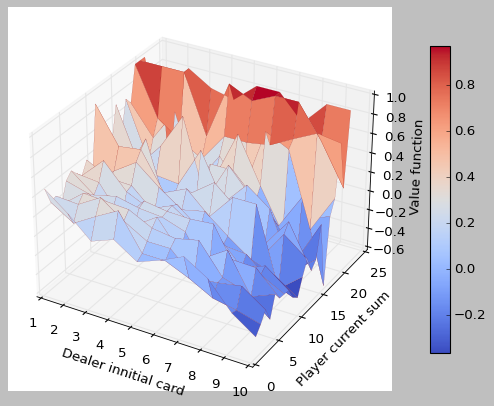

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

x = np.arange(1, 11)
y = np.arange(1, 22)
(x, y) = np.meshgrid(x, y)

# change the value of the "cmap" parameter
surf = ax.plot_surface(
    x,
    y,
    value_function_mc.T,
    rstride=1,
    cstride=1,
    cmap=cm.coolwarm,
    edgecolor="darkred",
    linewidth=0.1,
)

cax = ax.inset_axes([1.1, 0.1, 0.05, 0.8])
fig.colorbar(surf, shrink=0.5, aspect=10, cax=cax)
ax.set_xlabel("Dealer innitial card")
ax.set_ylabel("Player current sum")
ax.set_zlabel("Value function")

plt.show()

# Sarsa(lambda)

Let's implement Sarsa as a class as it appears easier to handle than what I already did for MC

In [8]:
class SarsaAgent:

    # Initialise all needed quantities
    def __init__(
        self,
        step_fn: Callable,
        policy_fn: Callable,
        lambda_value: int,
        discounting_factor: int = 1,
    ):
        self.n_occurences = np.zeros(shape=(10, 21, 2))
        self.q_values = np.zeros(shape=(10, 21, 2))

        self.lambda_value = lambda_value
        self.discounting_factor = discounting_factor
        self.step_fn = step_fn
        self.policy = policy_fn

    def start(self):
        """Instantiate the differnet objects that will be updated along the episode"""
        self.terminal_state_reached = False
        self.eligibilite_traces = np.zeros(shape=(10, 21, 2))
        initial_dealer_card = np.random.randint(1, 11)
        initial_player_card = np.random.randint(1, 11)
        self.last_state = [initial_dealer_card, initial_player_card]
        self.last_action_taken = np.random.randint(2)
        self.n_occurences[
            self.last_state[0] - 1, self.last_state[1] - 1, self.last_action_taken
        ] += 1

    def sample_sarsa_step(self):
        """Run a step of SARSA(lambda) update."""
        state, reward, self.terminal_state_reached = self.step_fn(
            s=self.last_state, a=self.last_action_taken
        )

        if self.terminal_state_reached:
            action = 0
            delta = (
                reward
                + 0
                - self.q_values[
                    self.last_state[0] - 1,
                    self.last_state[1] - 1,
                    self.last_action_taken,
                ]
            )
        else:
            action = self.policy(
                state=state, q_values=self.q_values, n_occurences=self.n_occurences
            )
            delta = (
                reward
                + self.discounting_factor
                * self.q_values[state[0] - 1, state[1] - 1, action]
                - self.q_values[
                    self.last_state[0] - 1,
                    self.last_state[1] - 1,
                    self.last_action_taken,
                ]
            )

        self.n_occurences[
            self.last_state[0] - 1, self.last_state[1] - 1, self.last_action_taken
        ] += 1

        self.eligibilite_traces[
            self.last_state[0] - 1, self.last_state[1] - 1, self.last_action_taken
        ] += 1

        alpha = 1 / np.sum(
            self.n_occurences[self.last_state[0] - 1, self.last_state[1] - 1]
        )

        self.q_values += alpha * delta * self.eligibilite_traces
        self.eligibilite_traces *= self.lambda_value * self.discounting_factor

        self.last_state = state
        self.last_action_taken = action

    def run_episode(self):
        """Run steps until a terminal state is reached."""
        # Initialize state along with eligibilty traces
        self.start()

        # Loop while state is not terminated
        while not self.terminal_state_reached:
            self.sample_sarsa_step()

### Plot MSE along episodes

In [9]:
mean_squared_errors = []
mean_squared_error_along_episodes = [[], []]
mean_squared_error_along_episodes_lambda_1 = []
for lambda_value in [0, 1]:
    sarsa_agent = SarsaAgent(step_fn=step, policy_fn=policy, lambda_value=lambda_value)

    num_episodes = 100000
    for episode in tqdm.tqdm(range(num_episodes)):
        sarsa_agent.run_episode()
        mean_squared_error_per_episode = np.mean(
            np.square(sarsa_agent.q_values - q_values_mc)
        )
        mean_squared_error_along_episodes[lambda_value].append(
            mean_squared_error_per_episode
        )

100%|██████████| 100000/100000 [00:05<00:00, 19350.06it/s]


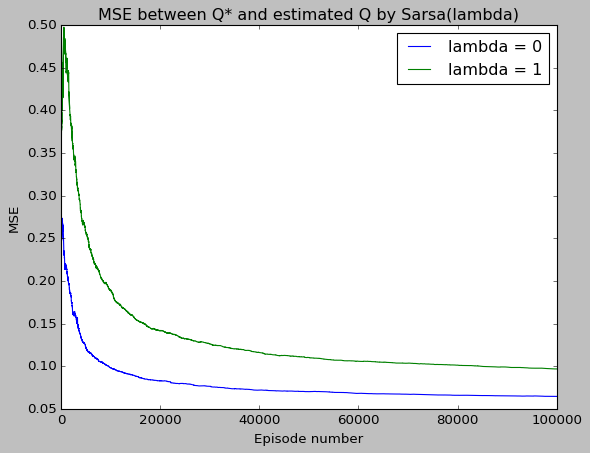

In [10]:
### Lambda 0
plt.plot(mean_squared_error_along_episodes[0])
plt.plot(mean_squared_error_along_episodes[1])

plt.ylabel("MSE")
plt.xlabel("Episode number")
plt.title("MSE between Q* and estimated Q by Sarsa(lambda)")
plt.legend(["lambda = 0", "lambda = 1"])

### Plot MSE according to lambda

In [11]:
mean_squared_errors = []
mean_squared_error_along_episodes_lambda_0 = []
mean_squared_error_along_episodes_lambda_1 = []
lambda_values = np.arange(0, 1.1, 0.1)
for lambda_value in lambda_values:
    sarsa_agent = SarsaAgent(step_fn=step, policy_fn=policy, lambda_value=lambda_value)

    num_episodes = 1000
    for episode in tqdm.tqdm(range(num_episodes)):
        sarsa_agent.run_episode()
        if lambda_value == 0:
            mean_squared_error_per_episode = np.mean(
                np.square(sarsa_agent.q_values - q_values_mc)
            )
            mean_squared_error_along_episodes_lambda_0.append(
                mean_squared_error_per_episode
            )
        elif lambda_value == 1:
            mean_squared_error_per_episode = np.mean(
                np.square(sarsa_agent.q_values - q_values_mc)
            )
            mean_squared_error_along_episodes_lambda_1.append(
                mean_squared_error_per_episode
            )
    mean_squared_error = np.mean(np.square(sarsa_agent.q_values - q_values_mc))
    mean_squared_errors.append(mean_squared_error)

100%|██████████| 1000/1000 [00:00<00:00, 20236.14it/s]


Text(0.5, 1.0, 'MSE between Q* and estimate Q by Sarsa(lambda)')

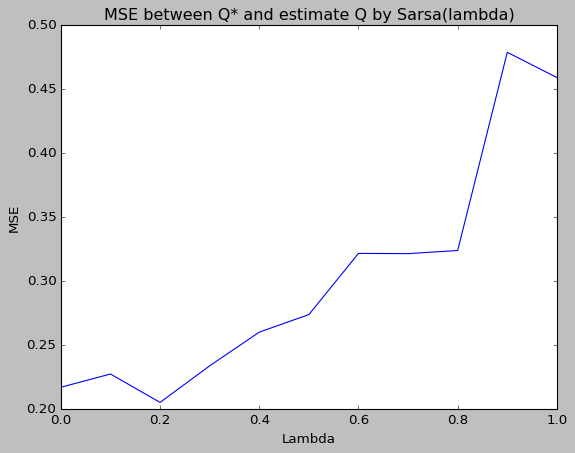

In [12]:
plt.plot(lambda_values, mean_squared_errors)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("MSE between Q* and estimate Q by Sarsa(lambda)")

### Value function estimated by Sarsa(1)

In [13]:
value_function = np.max(sarsa_agent.q_values, axis=-1)

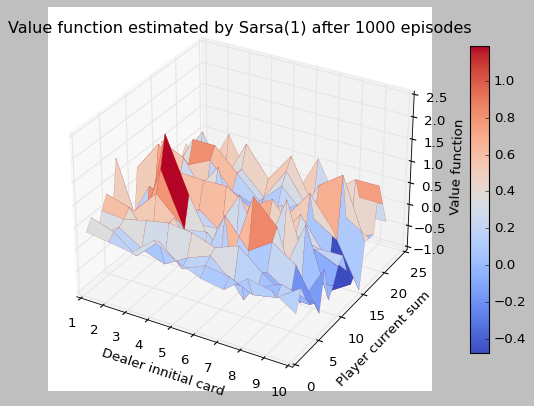

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

x = np.arange(1, 11)
y = np.arange(1, 22)
(x, y) = np.meshgrid(x, y)

# change the value of the "cmap" parameter
surf = ax.plot_surface(
    x,
    y,
    value_function.T,
    rstride=1,
    cstride=1,
    cmap=cm.coolwarm,
    edgecolor="darkred",
    linewidth=0.1,
)

cax = ax.inset_axes([1.1, 0.1, 0.05, 0.8])
fig.colorbar(surf, shrink=0.5, aspect=10, cax=cax)
ax.set_xlabel("Dealer innitial card")
ax.set_ylabel("Player current sum")
ax.set_zlabel("Value function")
ax.set_title("Value function estimated by Sarsa(1) after 1000 episodes")

plt.show()

# Linear function approximation

In [15]:
class SarsaAgentLinearApprox:

    # Initialise all needed quantities
    def __init__(
        self,
        step_fn: Callable,
        lambda_value: int,
        discounting_factor: int = 1,
        n_features: int = 36,
    ):
        self.n_features = n_features
        self.n_occurences = np.zeros((3, 6, 2))

        self.lambda_value = lambda_value
        self.discounting_factor = discounting_factor
        self.step_fn = step_fn

        # Linear Approximation
        self.dealers_intervals = [(1, 4), (4, 7), (7, 10)]
        self.player_intervals = [(1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21)]
        self.weights = np.random.randn(3, 6, 2)
        self.alpha = 0.01
        self.epsilon = 0.05

    def build_binary_feature_vector(
        self, x: int, intervals: List[Tuple[int, int]]
    ) -> np.ndarray:
        """Builds a binary vector where the intervals containing x are set to 1.

        Args:
            x (int): Input value.
            intervals (List[Tuple[int, int]]): Intervals.

        Returns:
            np.ndarray: Binary vector where the intervals containing x are set to 1.
        """
        return np.asarray([x1 <= x <= x2 for (x1, x2) in intervals], dtype=np.int32)

    def get_features(self, state: List[int], action: int) -> np.ndarray:
        """Returns the feature vector corresponding to the (state, action) pair.

        Args:
            state (List[int]): State.
            action (int): Action taken.

        Returns:
            np.ndarray: feature vector corresponding to the (state, action) pair.
        """

        features = np.zeros((3, 6, 2))
        dealer_features = self.build_binary_feature_vector(
            state[0], self.dealers_intervals
        )
        player_features = self.build_binary_feature_vector(
            state[1], self.player_intervals
        )

        state_grid = np.outer(dealer_features, player_features)
        features[:, :, action] = state_grid
        return features

    def q_values(self, state: List[int], action: int) -> float:
        """Computes the Q values corresponding to (state, action).

        Args:
            state (List[int]): State.
            action (int): Action taken.

        Returns:
            float: Q value corresponding to the pair (state, action).
        """
        features = self.get_features(state=state, action=action)
        q_value = np.sum(np.multiply(self.weights, features))
        return q_value

    def policy_linear_approx(self, state: List[int], q_values: np.ndarray) -> int:
        """Implements an epsilon-greedy policy that returns an action when given a state,
        the q_values for the current policy and the epsilon.

        Args:
            state (List[int]): Current state s = [dealer_first_card, player_current_sum].
            q_values (np.ndarray): Q values for each pair of (state, action).
            epsilon (float): Value of epsilon used for the epsilon greedy policy.

        Returns:
            int: Action chosen by the epsilon-greedy policy
        """

        # Get Q values for the state
        state_q_values = [q_values(state, 0), q_values(state, 1)]
        # Get the action that would be selected greedily
        greedy_a = np.argmax(state_q_values)

        # Draw a sample on the uniform distribution [0,1]
        p = np.random.uniform()

        # Again, this is simplified because there are only two actions and should be
        # modified for the general case if there are more than two actions.
        if p <= 1 - self.epsilon:
            return greedy_a
        else:
            return np.random.randint(2)

    def start(self):
        """Instantiate all objects that will be updated during the episode."""
        self.terminal_state_reached = False
        self.eligibilite_traces = np.zeros(shape=(3, 6, 2))
        initial_dealer_card = np.random.randint(1, 11)
        initial_player_card = np.random.randint(1, 11)
        self.last_state = [initial_dealer_card, initial_player_card]
        self.last_action_taken = np.random.randint(2)
        features = self.get_features(self.last_state, self.last_action_taken)
        self.n_occurences += features

    def sample_sarsa_step(self):
        """Sample a sarsa(lambda) step with linear Q value function approximation."""
        state, reward, self.terminal_state_reached = self.step_fn(
            s=self.last_state, a=self.last_action_taken
        )

        if self.terminal_state_reached:
            action = 0
            delta = reward + 0 - self.q_values(self.last_state, self.last_action_taken)
        else:
            action = self.policy_linear_approx(
                state=state, q_values=self.q_values, n_occurences=self.n_occurences
            )
            delta = (
                reward
                + self.discounting_factor * self.q_values(state, action)
                - self.q_values(self.last_state, self.last_action_taken)
            )

        last_state_action_features = self.get_features(
            state=self.last_state, action=self.last_action_taken
        )
        self.n_occurences += last_state_action_features

        self.eligibilite_traces = (
            self.eligibilite_traces * self.lambda_value * self.discounting_factor
            + last_state_action_features
        )
        self.weights += self.alpha * delta * self.eligibilite_traces

        self.last_state = state
        self.last_action_taken = action

    def run_episode(self):
        """Runs an entire episode while updating Sarsa agent's weights."""
        # Initialize state along with eligibilty traces
        self.start()

        # Loop while state is not terminated
        while not self.terminal_state_reached:
            self.sample_sarsa_step()

### Plot MSE according to lambda

In [16]:
mean_squared_error_by_lambda_value = []
for lambda_value in lambda_values:
    sarsa_agent = SarsaAgentLinearApprox(step_fn=step, lambda_value=lambda_value)

    num_episodes = 1000
    for episode in tqdm.tqdm(range(num_episodes)):
        sarsa_agent.run_episode()
    # Compute MSE
    mses = []
    for dealer_sum in range(1, 11):
        for player_sum in range(1, 22):
            for action in (0, 1):
                q_value_mc = q_values_mc[dealer_sum - 1, player_sum - 1, action]
                q_value_linear_approx = sarsa_agent.q_values(
                    (dealer_sum, player_sum), action
                )
                mses.append((q_value_mc - q_value_linear_approx) ** 2)
    mean_squared_error_per_episode = np.mean(mses)
    mean_squared_error_by_lambda_value.append(mean_squared_error_per_episode)

100%|██████████| 1000/1000 [00:00<00:00, 12173.63it/s]


Text(0.5, 1.0, 'MSE between Q* and estimate Q by Sarsa(lambda)')

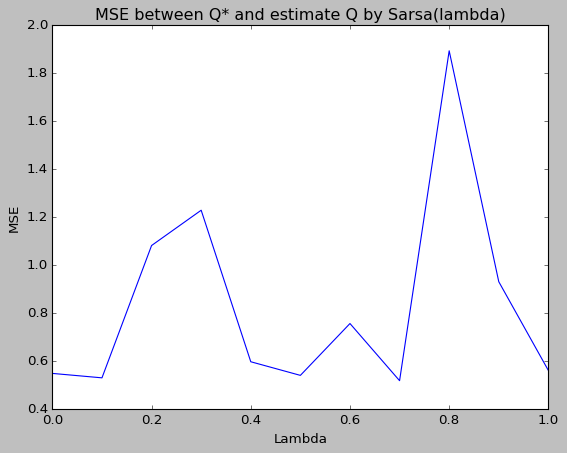

In [17]:
plt.plot(lambda_values, mean_squared_error_by_lambda_value)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("MSE between Q* and estimate Q by Sarsa(lambda)")

### Plot MSE according to lambda

In [18]:
mean_squared_error_along_episodes = [[], []]
for lambda_value in [0, 1]:
    sarsa_agent = SarsaAgentLinearApprox(step_fn=step, lambda_value=lambda_value)

    num_episodes = 10000
    for episode in tqdm.tqdm(range(num_episodes)):
        sarsa_agent.run_episode()
        # Compute MSE
        mses = []
        for dealer_sum in range(1, 11):
            for player_sum in range(1, 22):
                for action in (0, 1):
                    q_value_mc = q_values_mc[dealer_sum - 1, player_sum - 1, action]
                    q_value_linear_approx = sarsa_agent.q_values(
                        (dealer_sum, player_sum), action
                    )
                    mses.append((q_value_mc - q_value_linear_approx) ** 2)
        mean_squared_error_per_episode = np.mean(mses)
        mean_squared_error_along_episodes[lambda_value].append(
            mean_squared_error_per_episode
        )

100%|██████████| 10000/10000 [00:55<00:00, 181.04it/s]


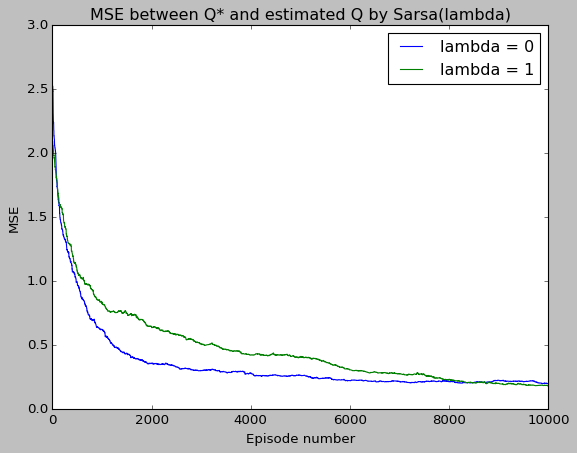

In [19]:
### Lambda 0
plt.plot(mean_squared_error_along_episodes[0])
plt.plot(mean_squared_error_along_episodes[1])

plt.ylabel("MSE")
plt.xlabel("Episode number")
plt.title("MSE between Q* and estimated Q by Sarsa(lambda)")
plt.legend(["lambda = 0", "lambda = 1"])

### Value function estimated by linear function approximation

In [20]:
q_values_linear = np.zeros((10, 21, 2))
for dealer_sum in range(1, 11):
    for player_sum in range(1, 22):
        for action in (0, 1):
            q_value_linear_approx = sarsa_agent.q_values(
                (dealer_sum, player_sum), action
            )
            q_values_linear[
                dealer_sum - 1, player_sum - 1, action
            ] = q_value_linear_approx

In [21]:
value_function_linear = np.max(q_values_linear, axis=-1)

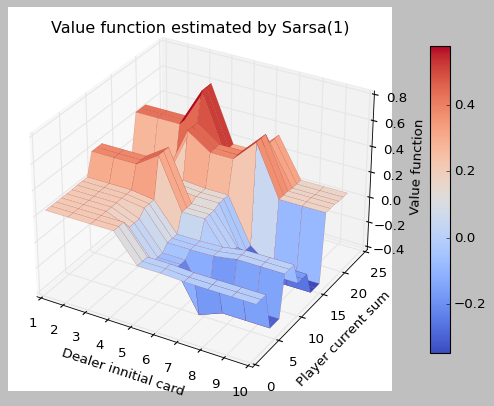

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

x = np.arange(1, 11)
y = np.arange(1, 22)
(x, y) = np.meshgrid(x, y)

# change the value of the "cmap" parameter
surf = ax.plot_surface(
    x,
    y,
    value_function_linear.T,
    rstride=1,
    cstride=1,
    cmap=cm.coolwarm,
    edgecolor="darkred",
    linewidth=0.1,
)

cax = ax.inset_axes([1.1, 0.1, 0.05, 0.8])
fig.colorbar(surf, shrink=0.5, aspect=10, cax=cax)
ax.set_xlabel("Dealer innitial card")
ax.set_ylabel("Player current sum")
ax.set_zlabel("Value function")
ax.set_title("Value function estimated by Sarsa(1)")

plt.show()